### Load and preprocess Data2
Tensorflow 2.0에 맞게 다시 Tensorflow를 살펴볼 필요가 있다고 느껴져서 <a href="https://www.tensorflow.org/?hl=ko">Tensorflow 정식 홈페이지</a>에 나와있는 예제부터 전반적인 Tensorflow 사용법을 먼저 익히는 Post가 된다.  
<br>

#### 필요한 Library Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_datasets as tfds
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import time
import sys

### Load images
Code 참조: <a href="https://www.tensorflow.org/tutorials/load_data/images?hl=ko">Tensorflow Core Load images</a>
<br>

#### Setup
<code>tf.data.Dataset</code>중 Image data를 처리하는 방법에 대해서 알아보자.  
먼저 <code>tf.keras.utils.get_file()</code>를 활용하여 URL에서 Image Format Dataset을 가져오자.  

URL의 실제 Dataset을 다운받으면 다음과 같이 구성되어 있다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Tensorflow/26.png" height="100%" width="100%" /></div><br>

따라서 아래 Code는 다음과 같은 의미가 있다.  
- <code>pathlib.Path(data_dir)</code>: Directory Path
- <code>len(list(data_dir.glob('*/*.jpg')))</code>: Directory Path에서 .jpg File 개수
- <code>np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])</code>: Directory Path 에서 LICENSE.txt를 제외한 File or Foler 이름(Class를 의미하게 된다.)
- <code>list(data_dir.glob('roses/*'))</code>: roses Folder의 모든 Image File List


3670
['dandelion' 'sunflowers' 'daisy' 'roses' 'tulips']


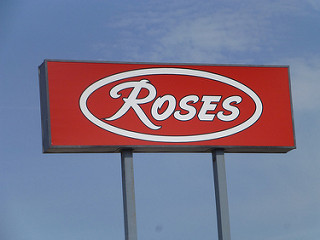

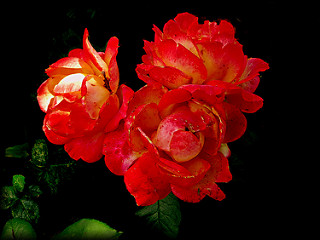

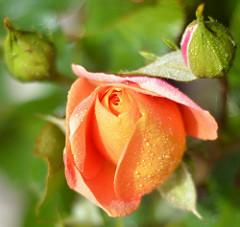

In [2]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# File 개수 측정
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

# Class 확인
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

# Image 확인
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

#### Load using keras.preprocessing
<code>tf.keras.preprocessing</code>을 활용하여 Image를 Load한다.  

**tf.keras.preprocessing.image.ImageDataGenerator()**: Generate batches of tensor image data with real-time data augmentation  
Parameter와 지원되는 Function이 너무 많이 깨문에 아래 링크를 참조하여 필요한 부분이나 모르는 부분을 참조하는 것을 추천한다.  

참조: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file?version=stable">tf.keras.utils.get_file() 설명</a> 

In [3]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# 나중에 Training에서 사용할 Step per epoch 선언
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# 위에서 선언한 image_generator를 통하여 Directory에 접근하여 Batch Image Data를 생성한다.
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


#### Show batch
위에서 Directory를 기준으로 Tensor로 바꾸었던 Image Tensor를 시각적으로 표현하고 알아본다.

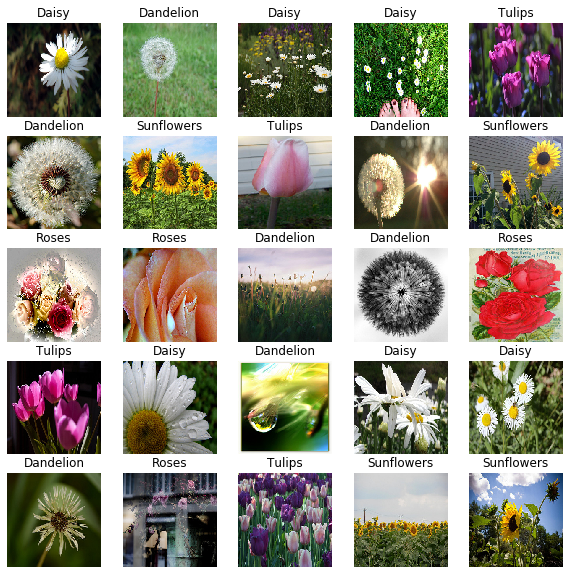

In [4]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#### Load using tf.data
위에서 keras.preprocessing을 사용하여 Tensor로서 Dataset을 구축하였지만 Tensorflow Guide에서는 다음과 같은 단점이 존재한다고 얘기한다.  
>1. It's slow. See the performance section below.
2. It lacks fine-grained control.
3. It is not well integrated with the rest of TensorFlow.
>

느리고, 세밀한 제어가 부족하고, Tensorflow와 연결하기 어렵다는 것 이다.  
아래는 Tensorflow의 tf.data.Dataset을 활용하여 Image Data -> Tensor로서 바꾸는 과정이다.  
아래 Code는 <code>tf.data.Dataset.list_files()</code>를 활용하여 실제 Image Data가 있는 Directory를 Tensor String으로서 변환시키는 작업이다.

In [5]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/6908789145_814d448bb1_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/15069459615_7e0fd61914_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4933229357_1c5cc03f65_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/20410697750_c43973d1eb.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/20165867412_fc45d31698_m.jpg'


#### Data 전처리
file_path를 입력받아 Label과 Image를 Input Data로서 사용하는 Code이다.  
현재 <code>tf.print()</code>를 통하여 Training도중의 값을 출력하며 Debug를 하였다.  
하지만 왜 Error가 발생하는지 모르겠다.  
추측으로는 Tensor와 Numpy를 비교하는데에서 Error가 발생한 것 같다. <code>CLASS_NAMES == parts[-2]</code>  
Training할 때 값이 빠져나와서 String형태가 된다면 비교가 가능해야 된다고 개인적으로 생각하나.... 비교 자체가 안되어서 뒷 부분은 실습을 진행 할 수 없었다.  
(Tensorflow 공식 홈페이지는 '2.1.0-dev20191111' Version을 사용하는데 현재 '2.0.0-beta1' Version을 사용하여서 Error가 발생하는 것 같다. 현재 정식 GitHub 홈페이지에 <a href="https://github.com/tensorflow/tensorflow/issues/35355">Issue</a>로서 남겨두었으니 답변이 달리면 좀 더 정확한 원인을 확인해보자.)  

CLASS_NAMES를 Numpy의 구조로서 선언하고 String값과 비교하게 되면 원래 다음과 같은 결과를 얻어야 한다.  
```python
a = 'tulips'
print(a == CLASS_NAMES) # [False False False False  True]
```
<br>
하지만 현재 FALSE로만 나오기 때문에 어디선가 Error가 발생했다고 예상은 하지만, 해결하지는 못하고 있다.  

**<span style="color:red">해결 방안</span>**  
현재 <a href="https://github.com/tensorflow/tensorflow/issues/35355">Issue</a>에서 답변은 이렇다.  
**Tensorflow 2.0 beta1에서는 작동하지 않지만, Tensorflow 2.0 에서는 작동한다.**  
Tensorflow 2.0 beta1이여서 발생하였던 문제였다.  
현재 Tesnrflow 2.0 Version으로 변경시 잘 작동되는 것을 확인하였다.  
참조: <a href="https://colab.research.google.com/gist/ravikyram/2fef781e3672efc80b454acd42e8ddb8/untitled497.ipynb">Tensorflow Version에 따른 Data전처리 결과</a>

In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    tf.print(parts, output_stream=sys.stderr)
    tf.print(parts[-2], output_stream=sys.stderr)
    
    return CLASS_NAMES == parts[-2]

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### AUTOTUNE
현재 정상적으로 작동하지 않으나, Autotune의 기능은 확인할 수 있어서 작성한다.  
<code>AUTOTUNE = tf.data.experimental.AUTOTUNE</code>은 작동하는 Network가 스스로 설정하고 Dataset을 잘 불러올 수 있게 결정하라는 것 이다.(상황에 따라서 동적으로 결정해라)  
**많은 양의 Data를 처리하는 경우 Load를 자동으로 해주기 때문에 속도가 빠라질 것으로 예상된다.**  
밑의 Code에서 비교할 수 있듯이, 기본적으로는 하나씩 처리하는 것이 맞으나... AutoTune을 사용하게 되면 속도가 빠르게 알아서 처리하는 것을 살펴볼 수 있다.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path)

print('Not AutoTune')
for image, label in labeled_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
print()
print('-'*50)
print('Use AutoTune')
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in labeled_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Not AutoTune
["" "root" ".keras" ... "flower_photos" "tulips" "8723767533_9145dec4bd_n.jpg"]
tulips
Image shape:  (224, 224, 3)
Label:  [False False False False  True]
["" "root" ".keras" ... "flower_photos" "sunflowers" "18828283553_e46504ae38.jpg"]
sunflowers
Image shape:  (224, 224, 3)
Label:  [False  True False False False]

--------------------------------------------------
Use AutoTune
["" "root" ".keras" ... "flower_photos" "dandelion" "2535727910_769c020c0d_n.jpg"]
["" "root" ".keras" ... "flower_photos" "sunflowers" "5830614551_e460a1215c.jpg"]
["" "root" ".keras" ... "flower_photos" "roses" "8063462557_e0a8bd6c64_n.jpg"]
sunflowers
["" "root" ".keras" ... "flower_photos" "tulips" "4679869990_7c5f28f2fe_n.jpg"]
["" "root" ".keras" ... "flower_photos" "sunflowers" "7510262868_cf7d6f6f25_n.jpg"]
["" "root" ".keras" ... "flower_photos" "sunflowers" "21518663809_3d69f5b995_n.jpg"]
["" "root" ".keras" ... "flower_photos" "dandelion" "7015947703_11b30c20c9_n.jpg"]
["" "root" ".keras

#### Basic methods for training
<code>tf.data</code>를 활용하여 Data를 선언하고 Batch처리를 한뒤 결과를 확인한다.  
<code>ds.prefetch()</code>을 활용하여 좀 더 빠르게 작동하도록 한다.  

**Prefatch**  
>Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

즉, Model이 Training하는 동안 데이터 전처리 작업을 쉬지 말고, 동적으로 전처리 과정을 동시에 진행하여 Model Training의 시간을 좀 더 단축시킬 수 있다는 의미이다.  

Tensorflow Guide는 위의 과정을 그림으로서 다음과 같이 나타내었다.  
<img src="https://www.tensorflow.org/guide/images/data_performance/naive.svg?hl=ko"><br>
사진 참조 <a href="https://www.tensorflow.org/guide/data_performance?hl=ko">data_performance 설명서</a>

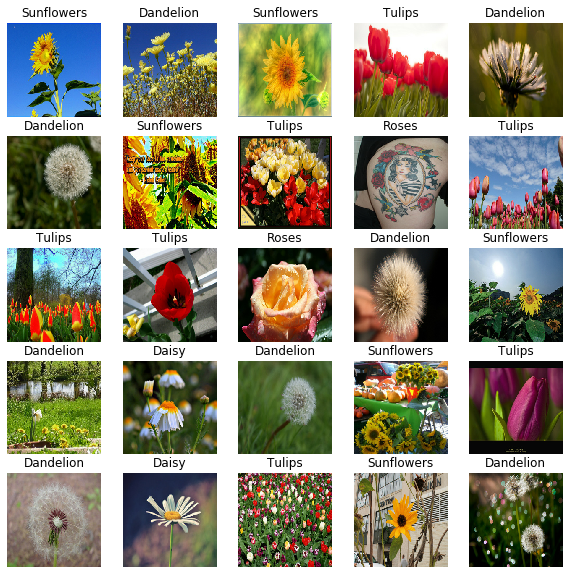

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    #tf.print(parts, output_stream=sys.stderr)
    #tf.print(parts[-2], output_stream=sys.stderr)
    
    return CLASS_NAMES == parts[-2]

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
        
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

#### Performance
tf.data를 사용하는 것과 keras.preprocessing의 실행 속도를 비교한다.  
최종적인 결과를 비교하면 다음과 같다.  
```code
....................................................................................................
1000 batches: 56.4826819896698 s
566.54534 Images/s
....................................................................................................
1000 batches: 3.5700411796569824 s
8963.48204 Images/s
```
<br>

tf.data를 사용하는 것이 약 15배이상 빠른 것으로 확인되었다.(Label을 비교하는 것에서 Error가 없어지면 tf.data를 사용하는 것이 훨씬 빠른속도로 Data의 전처리가 가능할 것 이다.)

In [9]:
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
    
# `keras.preprocessing`
timeit(train_data_gen)

# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 56.4826819896698 s
566.54534 Images/s
....................................................................................................
1000 batches: 3.5700411796569824 s
8963.48204 Images/s


### Load Text
Code 참조: <a href="https://www.tensorflow.org/tutorials/load_data/text?hl=ko#setup">Tensorflow Core Load text</a>
<br>

#### Setup
<code>tf.data.Dataset</code>중 Text data를 처리하는 방법에 대해서 알아보자.  
먼저 <code>tf.keras.utils.get_file()</code>를 활용하여 URL에서 Text Format Dataset을 가져오자.  

총 3개의 Text cowper.txt, derby.txt, butler.txt을 가져온다.

In [11]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
    text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL+name)

parent_dir = os.path.dirname(text_dir)

parent_dir

'/root/.keras/datasets'

#### Load text into datasets
- <code>tf.data.TextLineDataset()</code>: 지정한 Path의 TextFile을 읽어오는데 Line별로 읽어온다.  
- <code>labeler()</code>: Input의 Data와 Labeling을 지정한다. cowper.txt -> 0, derby.txt -> 1, butler.txt -> 2  
- <code>tf.dataset.map()</code>: dataset의 각각의 element에 Function을 할당한다.

결과를 확인하기 위하여 각각의 Text를 확인하면 다음과 같다.  

**cowper.txt**  
```code
Achilles sing, O Goddess! Peleus' son;
His wrath pernicious, who ten thousand woes
Caused to Achaia's host, sent many a soul
Illustrious into Ades premature,
And Heroes gave (so stood the will of Jove)
To dogs and to all ravening fowls a prey,

...

```
<br>

**derby.txt**  
```code
Of Peleus' son, Achilles, sing, O Muse,
The vengeance, deep and deadly; whence to Greece
Unnumbered ills arose; which many a soul
Of mighty warriors to the viewless shades
Untimely sent; they on the battle plain
Unburied lay, a prey to rav'ning dogs,
And carrion birds; but so had Jove decreed,
From that sad day when first in wordy war,
The mighty Agamemnon, King of men,

...

```
<br>

**butler.txt**  
```code
Sing, O goddess, the anger of Achilles son of Peleus, that brought
countless ills upon the Achaeans. Many a brave soul did it send
hurrying down to Hades, and many a hero did it yield a prey to dogs and
vultures, for so were the counsels of Jove fulfilled from the day on
which the son of Atreus, king of men, and great Achilles, first fell
out with one another.

...

```
<br>

In [16]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

# 각각의 File에 Label을 붙이는 작업
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

# labeld_data_sets[0] => cowper.txt Check
for s in labeled_data_sets[0].take(1):
    print(s)
    
# labeld_data_sets[0] => derby.txt Check
for s in labeled_data_sets[1].take(1):
    print(s)
    
# labeld_data_sets[0] => butler.txt Check
for s in labeled_data_sets[2].take(1):
    print(s)

(<tf.Tensor: id=608, shape=(), dtype=string, numpy=b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;">, <tf.Tensor: id=609, shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: id=619, shape=(), dtype=string, numpy=b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,">, <tf.Tensor: id=620, shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: id=630, shape=(), dtype=string, numpy=b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'>, <tf.Tensor: id=631, shape=(), dtype=int64, numpy=2>)


#### Load Shuffle and Batch datasets
위에서 3개의 Text File(cowper.txt, derby.txt, butler.txt)를 label_data_sets List로서 담았다.  
아래 Code는 이러한 List로서 담은 배열은 하나의 Dimension으로 합치는과 동새에 Shuffle까지 하는 과정이다.

In [27]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
    
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

print('Tensor Information')
# Tensor 확인
for ex in all_labeled_data.take(1):
    print(ex)

print()
print('Tensor Data Information')
# Tensor text, Label 출력
for text,label in all_labeled_data.take(5):
    print(text.numpy())
    print(label.numpy())
    print()

Tensor Information
(<tf.Tensor: id=889, shape=(), dtype=string, numpy=b'So in my inmost soul full well I know'>, <tf.Tensor: id=890, shape=(), dtype=int64, numpy=1>)

Tensor Data Information
b'So in my inmost soul full well I know'
1

b"Long doom'd by fate, again from death preserve?"
1

b'bronze was turned by bronze, and Hector was untouched, for the spear'
2

b'So saying, Hector of the glancing helm,'
1

b'full and the untiring sun, with all the signs that glorify the face of'
2



#### Build vocabulary
Text전처리를 위하여 Vocabulary를 작성한다.  
- <code>tfds.features.text.Tokenizer()</code>Text를 단어 단위로 Token을 만든다.  
- <code>vocabulary_set.update(some_tokens)</code>자른 단어를 Python Set 자료구조에 값을 넣는다.

Python Set은 중복을 허가하지 않는 자료구조 이므로 3개의 Text의 단어가 전부 vocabulary_set에 담길 것 이다.  
참조: <a href="https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer">tfds.features.text.Tokenizer 설명서</a>

In [32]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)

print('총 Vocab Size: ',vocab_size)
print()

print('Vocab 내용 확인')
for i,text in enumerate(vocabulary_set):
    print(text)
    if i ==3:
        break

총 Vocab Size:  17178

Vocab 내용 확인
excessive
Melanthius
Exulting
nevermore


#### Encode examples
<code>tfds.features.text.TokenTextEncoder()</code>는 Encoder 객체를 생성한다.  
<code>encoder.encode(example_text)</code>의 결과를 살펴보게 되면 Text를 Input으로 넣게 되면 Vocab의 Index로서 변환하게 된다.  
참조: <a href="https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder">tfds.features.text.TokenTextEncoder 설명서</a>

In [33]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)

encoded_example = encoder.encode(example_text)
print(encoded_example)

b'So in my inmost soul full well I know'
[4888, 11404, 6871, 4774, 5667, 8921, 1031, 5205, 15013]


#### Wrapping
아래 Code를 살펴보면 Function이 2개가 있다.  
- encode(): 위에서 선언한 Text -> Vocab -> Encoding Text로서 변환하는 작업이다.
- encode_map_fn(): <code>tf.py_function()</code>을 사용하여 Python Function을 Tensorflow Operation으로서 Wrapping을 한다.

**tf.py_function**  
Wraps a python function into a Tensorflow op thar executes it eagerly  
위의 설명을 예시를 들어서 설명하여 보자.  

1)먼저 Tensor Input으로 들어오게 됨으로서 encode_map_fn() Function에는 다음과 같은 Tensor가 들어오게 된다.  

```code
(<tf.Tensor: id=889, shape=(), dtype=string, numpy=b'So in my inmost soul full well I know'>, <tf.Tensor: id=890, shape=(), dtype=int64, numpy=1>)
```
<br>

2)이러한 Tensor를 Python Function에 넘기고 싶음으로 <code>tf.py_function()</code>을 사용하여 encode() Function으로 넘기게 된다.  
<br>

3)encode() Function에서는 Tensor를 Python에서 처리하기 위한 Numpy로서 변형(text_tnesor.numpy())로서 자료형을 변경하고 Encoding과정을 진행한다.  
<br>

4)Output을 받아서 Tout=()형태로서 encode_map_fn에서 Return한다.  

최종적으로 Text, Label 형태의 Tensor가 Input으로 들어오면 Encoding으로 변환하여 Encoding Text, Label형태로서 Output을 Return한다.  

참조: <a href="https://www.tensorflow.org/api_docs/python/tf/py_function?hl=ko&version=stable">tf.py_function 설명서</a>

In [34]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = all_labeled_data.map(encode_map_fn)

#### split the dataset into test and train batches
- <code>tf.data.skip()</code>: 지정한 Count만큼 Data를 Skip하고 진행한다. 즉, TAKE_SIZE 이후의 Dataset은 Train Data로서 사용하고 0 ~ TAKE_SIZE까지의 Data는 TestData로서 사용한다.
- <code>padded_batch()</code>: Batch로 만들 Dataset에 Padding을 준다.

**padded_batch**  
<code>padded_batch(batch_size, padded_shapes, padding_values=None, drop_remainder=False)</code>: Batch로 만들 Dataset에 Padding을 준다.  

- batch_size: 적용할 Batch Size
- padded_shapes: Padding을 적용하여 Output으로 만들 Dimension. 만약 -1로 사용하는 경우 Dataset에서 가장 큰 Dataset기준으로 Shape가 적용된다. Text의 길이가 다 다르므로 맞춰줘야 한다. 아래 결과를 보면 shape=(15,)이므로 가장 긴 Text의 단어수는 15개라는 의미이다.
- padding_values: Padding을 채울 값(Default 0)

아래에서 Padding을 채워서 Text Data를 완성시켰다.  
중요한 점은 <code>padding_values</code> Option을 사용 안하였으므로 Shape=(15,)에 맞게 0값으로 채워지게 되므로 Vocab의 값이 0이 추가되었다고 생각하고 <code>vocab_size +=1</code> 을 하여야 한다.

In [35]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

sample_text, sample_labels = next(iter(test_data))
print(sample_text[0], sample_labels[0])

vocab_size += 1

tf.Tensor(
[ 4888 11404  6871  4774  5667  8921  1031  5205 15013     0     0     0
     0     0     0], shape=(15,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


#### Build the Model
Text 처리를 위한 Embedding Layer와 LSTM으로서 Network를 구성한다.

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

# One or more dense layers.
# Edit the list in the `for` line to experiment with layer sizes.
for units in [64, 64]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1099456   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,178,115
Trainable params: 1,178,115
Non-trainable params: 0
_________________________________________________________________


#### Train and Evaluate Model

In [11]:
model.fit(train_data, epochs=3, validation_data=test_data)
eval_loss, eval_acc = model.evaluate(test_data)
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
697/697 [==============================] - 24s 34ms/step - loss: 0.5124 - accuracy: 0.7537 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
697/697 [==============================] - 19s 27ms/step - loss: 0.2957 - accuracy: 0.8683 - val_loss: 0.3897 - val_accuracy: 0.8286
Epoch 3/3
697/697 [==============================] - 19s 27ms/step - loss: 0.2180 - accuracy: 0.9063 - val_loss: 0.4160 - val_accuracy: 0.8324
     79/Unknown - 2s 25ms/step - loss: 0.4160 - accuracy: 0.8324
Eval loss: 0.416, Eval accuracy: 0.832
